In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
%matplotlib inline

from elo import Elo as ELO
from glicko2 import Glicko2 as GLICKO
import trueskill as ts

In [2]:
# source https://www.kaggle.com/thefc17/bundesliga-results-19932018/version/1
bl = pd.read_csv('Bundesliga_Results.csv', parse_dates=['Date'])

This dataset contains results from every Bundesliga match from 1993-1994 to 2017-2018. It also includes half time results, but only from 1995-96 to 2017-18. Columns include Division (denoted as D1), HomeTeam, AwayTeam, FTHG (final time home goals), FTAG (final time away goals), FTR (full time result), HTHG (half time home goals), HTAG (half time away goals), HTR (half time result), and season.

Data compiled into one file from this site: http://www.football-data.co.uk/germanym.php

In [3]:
# final bundesliga results taken from wikipedia
bl_eintracht = [5, 9, 17, None, None, 15, 13, 17, None, None, 16, None, 14, 14, 9, 13, 10, 17, None, 6, 13, 9, 16, 11, 8, 7]
bl_bayern = [1, 6, 2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 4, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1]
bl_vfl = [4, 1, 1, 3, 10, 4, 11, 3, 1, 3, 6, 7, 7, 9, 13, 6, 5, 1, 1, 2, 2, 7, 2, 3, 4, 2]
years = [pd.to_datetime(i+1, format='%Y') for i in range(1993, 2019)]

def get_standings(team):
    if team == 'einfrankfurt':
        return bl_eintracht
    elif team == 'bayernmunich':
        return bl_bayern
    elif team == 'dortmund':
        return bl_vfl
    else:
        return []

In [4]:
bl.sort_values(by='Date', inplace=True)
bl.reset_index(inplace=True)
bl.HomeTeam = bl.HomeTeam.apply(lambda x: x.lower().replace(' ', ''))
bl.AwayTeam = bl.AwayTeam.apply(lambda x: x.lower().replace(' ', ''))
# add draws to the winner, doesn't really matter
bl['home_win'] = np.where(bl.FTHG >= bl.FTAG, 1, 0)
bl['draw'] = np.where(bl.FTHG==bl.FTAG, 1, 0)
bl['away_win'] = np.where(bl.FTHG < bl.FTAG, 1, 0)
bl['winner'] = (bl.HomeTeam * (bl.home_win) + bl.AwayTeam * bl.away_win)
bl['loser'] = (bl.HomeTeam * (1 - bl.home_win) + bl.AwayTeam * (1 - bl.away_win))

print('Dataset contains {} matches from {} to {}. Home won {} ({}%). There were {} draws ({}%).'.format(len(bl), bl.Date.min().date(), bl.Date.max().date(), bl.home_win.sum(), int(100*bl.home_win.sum()/len(bl)), bl.draw.sum(), int(100*bl.draw.sum()/len(bl)) ))

Dataset contains 7650 matches from 1993-01-09 to 2018-12-05. Home won 5551 (72%). There were 1964 draws (25%).


In [5]:
bl.head(10)

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,home_win,draw,away_win,winner,loser
0,44,D1,1993-01-09,werderbremen,duisburg,1,5,A,NaN,NaN,NaN,1993-94,0,0,1,duisburg,werderbremen
1,42,D1,1993-01-09,m'gladbach,schalke04,3,2,H,NaN,NaN,NaN,1993-94,1,0,0,m'gladbach,schalke04
2,41,D1,1993-01-09,kaiserslautern,nurnberg,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,kaiserslautern,nurnberg
3,40,D1,1993-01-09,hamburg,leverkusen,2,1,H,NaN,NaN,NaN,1993-94,1,0,0,hamburg,leverkusen
4,39,D1,1993-01-09,fckoln,freiburg,2,0,H,NaN,NaN,NaN,1993-94,1,0,0,fckoln,freiburg
5,38,D1,1993-01-09,einfrankfurt,karlsruhe,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,einfrankfurt,karlsruhe
6,37,D1,1993-01-09,dortmund,dresden,4,0,H,NaN,NaN,NaN,1993-94,1,0,0,dortmund,dresden
7,36,D1,1993-01-09,bayernmunich,leipzig,3,0,H,NaN,NaN,NaN,1993-94,1,0,0,bayernmunich,leipzig
8,43,D1,1993-01-09,wattenscheid,stuttgart,2,4,A,NaN,NaN,NaN,1993-94,0,0,1,stuttgart,wattenscheid
9,87,D1,1993-02-10,schalke04,werderbremen,1,1,D,NaN,NaN,NaN,1993-94,1,1,0,schalke04,werderbremen


In [6]:
teams = list(set(list(bl.winner.values) + list(bl.loser.values)))

In [7]:
# dictionary from team to DF row
participation = defaultdict(list)

# dictionary from team to match date for plotting
match_dates = defaultdict(list)

for idx, row in bl.iterrows():        
    match_dates[row.HomeTeam].append(row.Date)
    match_dates[row.AwayTeam].append(row.Date)
    participation[row.HomeTeam].append(idx)
    participation[row.AwayTeam].append(idx)

## Some utility functions

In [8]:
def get_matchup(row):
    if row.FTR == 'A':
        return (False, False)
    elif row.FTR == 'H':
        return (True, False)
    elif row.FTR == 'D':
        return (True, True)
    else:
        return(None, None)

In [9]:
# use a generic function to update rating dictionaries with match results
def update_ratings(calc, source, winner, loser, draw):
    winner_rating = source[winner][-1]
    loser_rating = source[loser][-1]
    winner_rating_new, loser_rating_new = calc.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    source[winner].append(winner_rating_new)
    source[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [10]:
# normalize array of ratings of one team with min/max values of all teams
def normalize(ratings, team):
    # skip the first 10% values to avoid calibration jumps offsetting the totals
    start_val = int(0.1*len(ratings))
    max_rating = max([max(i[start_val:]) for i in ratings.values()])
    min_rating = min([min(i[start_val:]) for i in ratings.values()])
    ratings = np.array(ratings[team])
    return (ratings - min_rating) / (max_rating - min_rating)

In [11]:
# could also use the one in sklearn.metrics
def brier_score(preds, outs):
    return np.average((outs - preds) ** 2)

## Elo

In [12]:
#Init signature: ELO(k_factor=10, rating_class=<class 'float'>, initial=1200, beta=200)
Elo_def = ELO(beta=200)
Elo_30 = ELO(k_factor=30, beta=200)
Elo_60 = ELO(k_factor=60, beta=200)

In [13]:
# keep ratings in a dictionary with list of ratings per team
# populate them with default values
elo_def_ratings = defaultdict(list)
elo_30_ratings = defaultdict(list)
elo_60_ratings = defaultdict(list)

for team in teams:
    elo_def_ratings[team].append(Elo_def.create_rating())
    elo_30_ratings[team].append(Elo_30.create_rating())
    elo_60_ratings[team].append(Elo_60.create_rating())

In [14]:
# go through the dataframe row by row and update the rating dictionaries
for idx, row in bl.iterrows():
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    for calc, source in zip([Elo_def, Elo_30, Elo_60], [elo_def_ratings, elo_30_ratings, elo_60_ratings]):
        update_ratings(calc, source, winner, loser, draw)

In [15]:
# create a dataframe that contains the rating of the team before the match on dates when they played
ratings = pd.DataFrame({'date': bl.Date.unique()})
for team in teams:
    ratings = ratings.merge(pd.DataFrame({'date': match_dates[team], team+'_elo_60': elo_60_ratings[team][:-1], team+'_elo_30': elo_30_ratings[team][:-1], team+'_elo_10': elo_def_ratings[team][:-1]}), how='left')

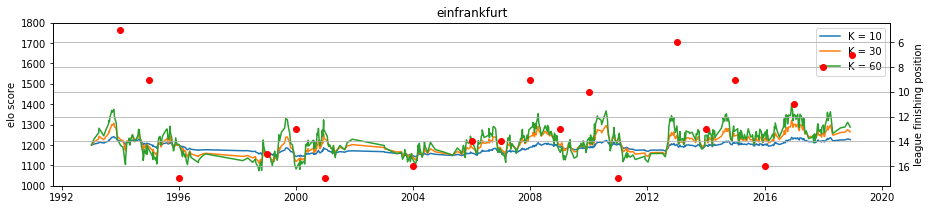

In [16]:
team = 'einfrankfurt'
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(match_dates[team], np.array(elo_def_ratings[team][:-1]), label='K = 10')
ax.plot(match_dates[team], np.array(elo_30_ratings[team][:-1]), label='K = 30')#

ax.plot(match_dates[team], np.array(elo_60_ratings[team][:-1]), label='K = 60')

ax1 = plt.twinx(ax)
ax1.plot(years, get_standings(team), 'ro')
ax1.invert_yaxis()
ax1.set_ylabel('league finishing position')
ax.set_ylabel('elo score')

ax.set_ylim(1000, 1800)

plt.grid()
ax.legend()
_ = plt.title(team)

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Elo')

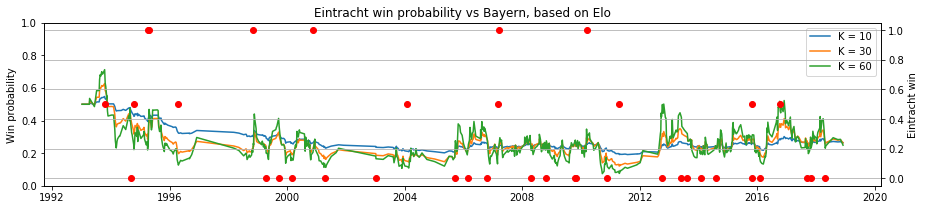

In [17]:
# this part of the code is fairly specific for bayern/eintracht, but easy to abstract if needed...

# computes the expected win probability from elo ratings
def expect(ratings, alg):
    R_E = ratings['einfrankfurt']
    R_B = ratings['bayernmunich']
    E = []
    for r1, r2 in zip(R_E, R_B):
        E.append(alg.expect(r1, r2))
    return E

# get all dataframe rows where bayern and eintracht faced off
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]

# get win percentage
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

# insert numeric winner in the dataframe
teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw

# calculate and plot expected win probability and actual winner
fig, ax = plt.subplots(figsize=(15,3))
for ratings, alg, label in zip([elo_def_ratings, elo_30_ratings, elo_60_ratings], [Elo_def, Elo_30, Elo_60], [' 10', ' 30', ' 60']):
    ax.plot(match_dates['einfrankfurt'], expect(ratings, alg)[:-1], label='K ='+label)
ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')
ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Elo')

## Glicko

In [18]:
# set up two Glicko 2 modules, one with sort of high sigma/tau values, one with low ones
tau_high = 1.2
sigma_high = .15
tau_low = .2
sigma_low = .06
# for some reason sublee refers to RD as phi in his code, even though phi is rescaled RD in the paper
Glicko_high = GLICKO(mu=1500, phi=350, tau=tau_high, sigma=sigma_high)
Glicko_low = GLICKO(mu=1500, phi=350, tau=tau_low, sigma=sigma_low)

In [19]:
# returns the lowest confidence interval mu - 2*RD
def apply_confidence_glicko(glicko_rating):
    skill = []
    for r in glicko_rating:
        skill.append(r.mu - 2*r.phi)
    return np.array(skill)

In [20]:
# the code below is used to calculate the glicko ratings with one day set as rating period

match_days = set(bl.Date) # need this to allow timestamp comparison
day_delta = datetime.timedelta(days=1)
start_date = bl.Date.min()
end_date = bl.Date.max() + day_delta
    
def get_daily_ratings(calc, gl_ratings):
    # since no team plays twice on the same day, we don't need to worry about series, 
    # but we still need to increase uncertainty on days without matches
    # of course the entire idea of using a day as series is not in the spirit of G2
    day_range = []
    for i in range((end_date - start_date).days):
        date = start_date + i * day_delta
        day_range.append(date)
        if date in match_days:
            # if there were matches on this date, get the teams that have played and update their ratings
            subdat = bl[bl.Date == date]
            teams_played = set(list(subdat.HomeTeam) + list(subdat.AwayTeam))
            for idx, row in subdat.iterrows():
                winner_is_home, draw = get_matchup(row)
                if winner_is_home:
                    winner = row.HomeTeam
                    loser = row.AwayTeam
                else:
                    winner = row.AwayTeam
                    loser = row.HomeTeam
                update_ratings(calc, gl_ratings, winner, loser, draw)
            teams_not_played = [i for i in teams if i not in teams_played]
        else:
            teams_not_played = teams
        # for the teams who did not play, we only need to update their RD based on the volatility
        for team in teams_not_played:
            rating = gl_ratings[team][-1]
            phi_star = np.sqrt(rating.phi ** 2 + rating.sigma ** 2)
            new_rating = calc.create_rating(rating.mu, phi_star, rating.sigma)
            gl_ratings[team].append(new_rating)
    return gl_ratings, day_range

In [21]:
# this code is used to calculate the glicko ratings with one BL season set as rating period

season_start_date = bl.groupby('Season').first().Date

def get_seasonal_ratings(calc, gs_ratings):
    for season in seasons:
        seasonal = bl[bl.Season == season]
        # each team gets an updated ratind for the season, but this rating cannot be used
        # for rating other teams in the same season, hence we keep it as provisional for now
        provisional_ratings = {}
        # now go through our list of teams and get their series = all the matches they had in
        # the season
        for team in teams:
            # get all matches played by the team
            relevant = seasonal[(seasonal.HomeTeam == team) | (seasonal.AwayTeam == team)]
            old_rating = gs_ratings[team][-1]
            # rewrite the matches in the format taken by the algroithm, which is [(result, opponent_rating)]
            series = []
            for idx, row in relevant.iterrows():
                if row.winner == team:
                    if row.draw:
                        series.append((0.5, gs_ratings[row.loser][-1]))
                    else:
                        series.append((1, gs_ratings[row.loser][-1]))
                else:
                    series.append((0, gs_ratings[row.winner][-1]))
            if len(series) > 0:
                new_rating = calc.rate(old_rating, series)
            else:
                # if the team didn't play that season, the series will be empty
                # the glicko implementation breaks here, so we fix it directly
                # only step 6 of the algorithm should be applied => increase phi
                # this should not be necessary once my PR is accepted by sublee
                phi_star = np.sqrt(old_rating.phi ** 2 + old_rating.sigma ** 2)
                new_rating = calc.create_rating(old_rating.mu, phi_star, old_rating.sigma)
            provisional_ratings[team] = new_rating
        for k, v in provisional_ratings.items():
            gs_ratings[k].append(v)
    return gs_ratings

In [22]:
# calculate daily ratings
gl_ratings_high = defaultdict(list)
for team in teams:
    gl_ratings_high[team].append(Glicko_high.create_rating(mu=1500, phi=350))

gl_ratings_low = defaultdict(list)
for team in teams:
    gl_ratings_low[team].append(Glicko_low.create_rating(mu=1500, phi=350))

gl_ratings_high, _ = get_daily_ratings(Glicko_high, gl_ratings_high)
gl_ratings_low, day_range = get_daily_ratings(Glicko_low, gl_ratings_low)


In [24]:
# calculate seasonal ratings
seasons = bl.Season.unique()
gs_ratings_high = defaultdict(list)
for team in teams:
    gs_ratings_high[team].append(Glicko_high.create_rating(mu=1500, phi=350))

gs_ratings_low = defaultdict(list)
for team in teams:
    gs_ratings_low[team].append(Glicko_low.create_rating(mu=1500, phi=350))

gs_ratings_high = get_seasonal_ratings(Glicko_high, gs_ratings_high)
gs_ratings_low = get_seasonal_ratings(Glicko_low, gs_ratings_low)

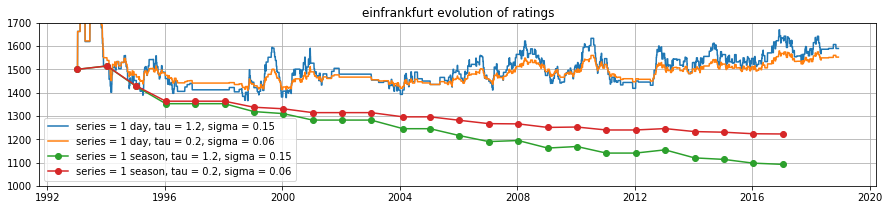

In [25]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.mu for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(day_range, [i.mu for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(season_start_date, [i.mu for i in gs_ratings_high[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(season_start_date, [i.mu for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.ylim(1000, 1700)
plt.grid()
plt.legend(loc='lower left')
_ = plt.title(team + ' evolution of ratings')

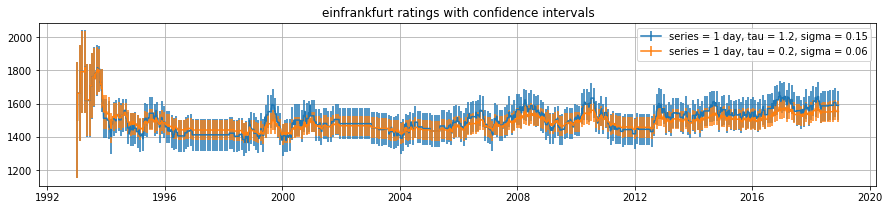

In [26]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.errorbar(day_range, [i.mu for i in gl_ratings_high[team][:-1]], yerr=[i.phi for i in gl_ratings_high[team][:-1]], errorevery=30, label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.errorbar(day_range, [i.mu for i in gl_ratings_low[team][:-1]], yerr=[i.phi for i in gl_ratings_low[team][:-1]], errorevery=30, label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.legend()
_ = plt.title(team + ' ratings with confidence intervals')

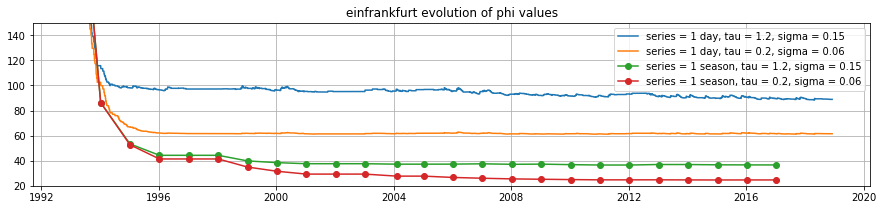

In [27]:
# plot season and day wide glicko phi
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.phi for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.plot(day_range, [i.phi for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(season_start_date, [i.phi for i in gs_ratings_high[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(season_start_date, [i.phi for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.ylim(20, 150)


plt.legend()
_ = plt.title(team + ' evolution of phi values')

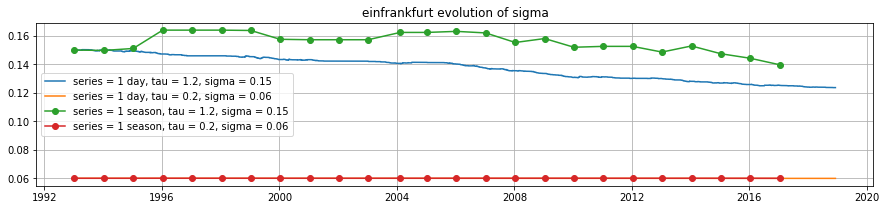

In [28]:
# plot season and day wide glicko sigma
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.sigma for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.plot(day_range, [i.sigma for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(season_start_date, [i.sigma for i in gs_ratings_high[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))

plt.plot(season_start_date, [i.sigma for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.legend()
_ = plt.title(team + ' evolution of sigma')

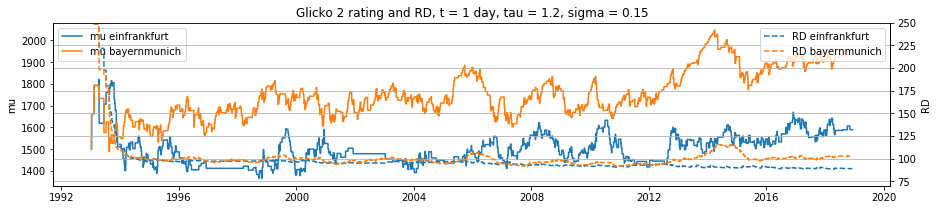

In [29]:
# plot mu and rd for Bayern and Eintracht daily

team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(day_range, np.array([i.mu for i in gl_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(day_range, np.array([i.phi for i in gl_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(day_range, np.array([i.mu for i in gl_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(day_range, np.array([i.phi for i in gl_ratings_high[team][:-1]]), '--', label='RD ' + team)

ax2.set_ylim(70,250)
ax1.legend()
ax2.legend()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
plt.grid()
_ = plt.title('Glicko 2 rating and RD, t = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))

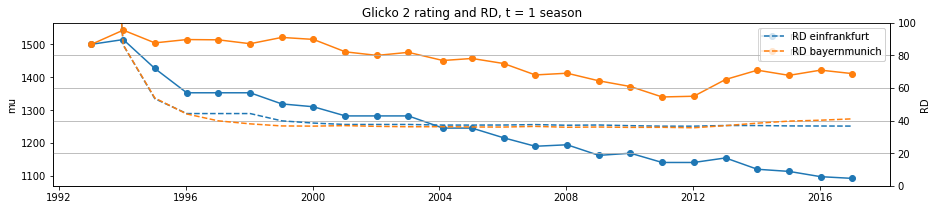

In [30]:
# plot mu and rd for Bayern and Eintracht seasonal
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

plt.grid()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
ax2.set_ylim(0,100)

ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

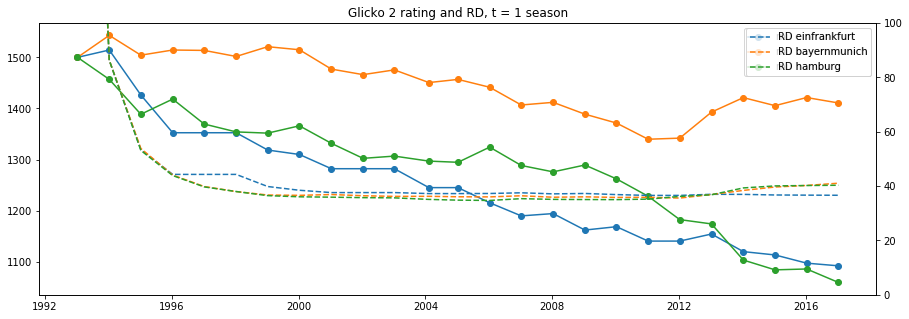

In [31]:
# plot mu and rd
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'hamburg'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

ax2.set_ylim(0, 100)

ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

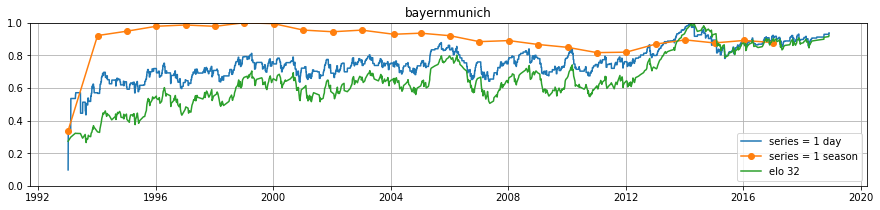

In [32]:
# plot normalised season and day wide glicko and elo for comparison
# what we see is that even if normalized these values aren't comparable
team = 'bayernmunich'
plt.figure(figsize=(15,3))
glicko_conf = dict(zip(teams, [apply_confidence_glicko(gl_ratings_high[i]) for i in teams]))
plt.plot(day_range, normalize(glicko_conf, team)[:-1], label='series = 1 day')
glicko_conf = dict(zip(teams, [apply_confidence_glicko(gs_ratings_high[i]) for i in teams]))
plt.plot(season_start_date, normalize(glicko_conf, team)[:-1], '-o', label='series = 1 season')
plt.plot(match_dates[team], normalize(elo_30_ratings, team)[:-1], label='elo 32')
plt.ylim(0,1)
plt.grid()
plt.legend()
_ = plt.title(team)

In [33]:
def predict_glicko_winner(calc, r1, r2):
    r1_g2 = calc.scale_down(r1)
    r2_g2 = calc.scale_down(r2)
    # equivalent to calling Glicko.reduce_impact
    g = 1 / np.sqrt(1+3*r1_g2.phi **2 / np.pi**2)
    # equivalent to calling Glicko.expect_score
    E = 1 / (1 + np.exp(-g * (r1_g2.mu - r2_g2.mu)))
    return E
    
# wrapper to call the above function with different dictionaries/classes
def predict_glicko_winners(ratings, calc, team1, team2):
    preds = []
    for r1, r2 in zip(ratings[team1], ratings[team2]):
        preds.append(predict_glicko_winner(calc, r1, r2))
    return preds

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Glicko-2')

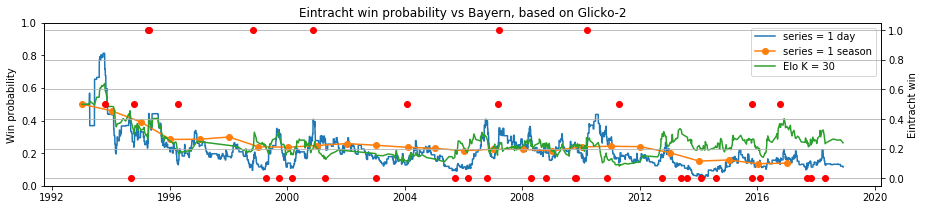

In [34]:
# make a nice plot of win probabilities like the one we did for elo
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw
fig, ax = plt.subplots(figsize=(15,3))

preds = predict_glicko_winners(gl_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(day_range, preds[:-1], label='series = 1 day')

#preds = predict_glicko(gl_ratings_low, Glicko_low, 'einfrankfurt', 'bayernmunich')
#ax.plot(day_range, preds[:-1])

preds = predict_glicko_winners(gs_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(season_start_date, preds[:-1], '-o', label='series = 1 season')

#preds = predict_glicko(gs_ratings_low, Glicko_low, 'einfrankfurt', 'bayernmunich')
#ax.plot(season_start_date, preds[:-1])

ax.plot(match_dates['einfrankfurt'], expect(elo_30_ratings, Elo_30)[:-1], label='Elo K = 30')


ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')

ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Glicko-2')

## Trueskill 

In [35]:
ts_calc = ts.TrueSkill(backend='scipy')

In [36]:
# probably won't have time for this in the presentation, but for the sake of completenes...
ts_ratings = defaultdict(list)
for team in teams:
    ts_ratings[team].append(ts_calc.Rating(mu=25.0, sigma=8.33))

In [37]:
# go through the dataframe row by row and update the rating dictionaries
for idx, row in bl.iterrows():
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    winner_new, loser_new = ts_calc.rate_1vs1(ts_ratings[winner][-1], ts_ratings[loser][-1], drawn=draw)
    ts_ratings[winner].append(winner_new)
    ts_ratings[loser].append(loser_new)

In [38]:
import itertools
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    BETA = ts.BETA
    denom = np.sqrt(size * (BETA * BETA) + sum_sigma)
    return ts_calc.cdf(delta_mu / denom)

In [39]:
ts_ratings['bayernmunich']

[trueskill.Rating(mu=25.000, sigma=8.330),
 trueskill.Rating(mu=29.394, sigma=7.169),
 trueskill.Rating(mu=33.069, sigma=6.238),
 trueskill.Rating(mu=31.720, sigma=4.963),
 trueskill.Rating(mu=30.898, sigma=4.211),
 trueskill.Rating(mu=27.209, sigma=3.770),
 trueskill.Rating(mu=28.173, sigma=3.539),
 trueskill.Rating(mu=26.425, sigma=3.268),
 trueskill.Rating(mu=25.351, sigma=3.064),
 trueskill.Rating(mu=26.604, sigma=2.870),
 trueskill.Rating(mu=26.001, sigma=2.626),
 trueskill.Rating(mu=26.633, sigma=2.519),
 trueskill.Rating(mu=25.885, sigma=2.349),
 trueskill.Rating(mu=25.627, sigma=2.207),
 trueskill.Rating(mu=26.123, sigma=2.136),
 trueskill.Rating(mu=26.556, sigma=2.027),
 trueskill.Rating(mu=27.143, sigma=1.963),
 trueskill.Rating(mu=26.817, sigma=1.873),
 trueskill.Rating(mu=27.186, sigma=1.828),
 trueskill.Rating(mu=26.753, sigma=1.755),
 trueskill.Rating(mu=26.229, sigma=1.709),
 trueskill.Rating(mu=26.084, sigma=1.649),
 trueskill.Rating(mu=26.385, sigma=1.617),
 trueskill.

In [40]:
p_draw = bl.draw.sum() / len(bl)
beta = 8.333 / 2
from scipy.stats import norm

def win_probability(r1, r2):
    delta_mu = r1.mu - r2.mu
    sigmas = np.array([r1.sigma, r2.sigma, np.sqrt(2)*beta])
    p_1 = norm.cdf(delta_mu / np.linalg.norm(sigmas))
    p_2 = 1 - p_1
    ## correct for draws
    #p_1 -= 0.5 * p_draw
    #p_2 -= 0.5 * p_draw
    #if p_1 < 0:
    #    p_1 = 0
    #    p_2 += np.abs(p_1)
    #if p_2 < 0:
    #    p2 = 0
    #    p_1 += np.abs(p_2)
    return p_1, p_2, p_draw

def win_probabilities(ratings1, ratings2):
    probs = []
    for r1, r2 in zip(ratings1, ratings2):
        p1, p2, pd = win_probability(r1, r2)
        probs.append(p1)
    return probs    

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Glicko-2')

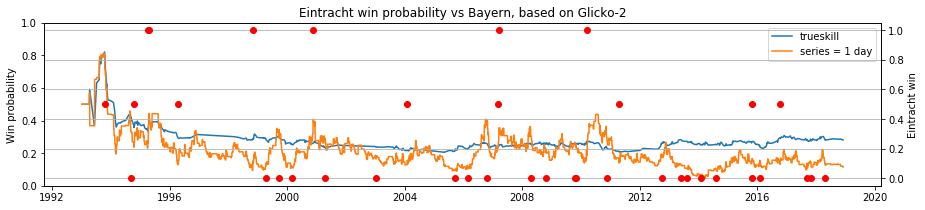

In [41]:
# make a nice plot of win probabilities like the one we did for elo
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw
fig, ax = plt.subplots(figsize=(15,3))

preds = win_probabilities(ts_ratings['einfrankfurt'], ts_ratings['bayernmunich'])
ax.plot(match_dates['einfrankfurt'], preds[:-1], label='trueskill')

preds = predict_glicko_winners(gl_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(day_range, preds[:-1], label='series = 1 day')



ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')

ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Glicko-2')